# Thickness calculation using 2-beam CBED
From the Howie-Whelan equations can be derived that we should see fringes in the CBED discs, with the spacing of the fringes goverened by:

\begin{equation}
\frac{s_k^2}{n_k^2} + \frac{1}{\xi_g^2 n_k^2} = \frac{1}{t^2}
\end{equation}

Here $\xi_g$ is the extinction distance for reflection $g$, $t$ is the thickness, $n_k = k + i$ with $i$ a to be determined integer. The spacing between consecutive fringes is described by $s_k$:

\begin{equation}
s_k = \frac{\lambda \Delta \theta_k}{2 \theta_g d_g^2} 
\end{equation}

Here, $\lambda$ is the electron wavelength, $\Delta \theta_k$ is the angular increment from the central fringe to the $k$th fringe, $\theta_g$ is the Bragg angle for reflection $g$ and $d_g$ is the interplanar spacing for the planes corresponding to $g$. Using Bragg's law $2 d_g \sin{\theta_g} \approx 2 d_g \theta_g = n \lambda$. Setting $n=1$ for simplicity:

\begin{equation}
s_k = \frac{\lambda \Delta \theta_k}{2 \theta_g \left(\frac{\lambda}{2 \theta_g}\right)^2} = \frac{2 \Delta \theta_k \theta_g}{\lambda}
\end{equation}

Filling into the first equation equation and a bit of re-arrangement:

\begin{equation}
\frac{4 (\Delta \theta_k)^2 \theta_g^2}{\lambda^2} = \frac{n_k^2}{t^2} - \frac{1}{\xi_g^2} 
\end{equation}

\begin{equation}
\Delta \theta_k= \frac{\lambda}{2 \theta_g}\sqrt{\frac{n_k^2}{t^2} - \frac{1}{\xi_g^2}} = \frac{1}{|g|}\sqrt{\frac{n_k^2}{t^2} - \frac{1}{\xi_g^2}}
\end{equation}

In the diffraction pattern $\Delta \theta_k$ scales approximately linearly with reciprocal distance (real distance on the detector i.e. pixels on the CCD provided camera length stays the same). So we can conclude that the fringe spacing decreases with:

* **as $\theta_g$ or $|g|$ increases**: choosing a further off reflection
* **as $\lambda$ decreases**: higher kV will decrease fringe spacing
* **as $t$ increases**: thicker means more fringes
* **as $\xi_g$ decreases**: smaller extinction distance yields smaller spacing. Often closer reflection have smaller $\xi_g$.

$\theta_g$ and $\xi_g$ compete, let's do some calculations for copper

In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [54]:
# constants

def getElectronWavelength(ht):
    """Get the electron wavelength in m from the high voltage in V"""
    # ht in Volts, length unit in meters
    h = 6.6e-34
    m = 9.1e-31
    charge = 1.6e-19
    c = 3e8
    wavelength = h / math.sqrt(2 * m * charge * ht)
    relativistic_correction = 1 / math.sqrt(1 + ht * charge/(2 * m * c * c))
    return wavelength * relativistic_correction


def dhkl(hkl, a):
    """hkl plane spacing for cubic materials"""
    h, k, l = hkl
    return a/np.sqrt(h**2+k**2+l**2)


def ghkl(hkl, a):
    """|g| for reflection (hkl) in cubic materials"""
    return 1/dhkl(hkl, a)

def theta_g(hkl, a, lam):
    return np.arcsin(lam/2/dhkl(hkl, a))

def f_g_cu(s):
    """Atomic scattering of Cu
    From table 3 in:
    https://journals.iucr.org/a/issues/1968/03/00/a05916/a05916.pdf
    
    s is in 1/angstrom
    f is in angstrom
    """
    a = np.array([1.5792, 1.8197, 1.6576, 0.5323])
    b = np.array([62.9403, 12.4527, 2.5042, 0.3331])
    E = 0.1004
    f = np.sum(a*np.exp(-b*s**2), axis=0)+E
    return f

f_g_vec = np.vectorize(f_g_cu) # for inspecting atomic scattering function

def Fg_fcc(hkl, a, voltage, fg):
    """
    Magnitude of structure factor of simple fcc metal, in angstrom
    
    a is in nm
    Atomic scattering factor fg must also be supplied as function of s (1/angstrom) and returns angstroms
    """
    # calculate the scattering angle
    h, k, l = hkl
    lam = getElectronWavelength(voltage)*1e10 # needs to be in angstrom for formula
    th_g = theta_g(hkl, a, lam/10) # a is in nm
    # calculate the atomic scattering factor
    s = np.sin(th_g)/lam 
    f_s = fg(s)
    # calculate the structure factor for fcc
    F = f_s*(1+np.exp(np.pi*1j*(h+k))+np.exp(np.pi*1j*(h+l))+np.exp(np.pi*1j*(l+k)))
    return abs(F)
    
# match between table 13.2 in W&C is good
def xi_g(voltage, hkl, a, f_g, verbose=False):
    """
    Extinction distance for reflection g in an FCC material in nm
    
    Supply lattice parameter a in nm
    voltage in V
    """
    lam = getElectronWavelength(voltage)*1e9 # in nm
    th_g = theta_g(hkl, a, lam)
    Fg_mag = Fg_fcc(hkl, a, voltage, f_g)/10 # in nm
    Vc = a**3
    if verbose:
        print("Wavelenght (nm): ", lam)
        print("Angle (radians): ", th_g)
        print("F_g (nm): ", Fg_mag)
        print("V_c (nm^3): ", Vc)
    return np.pi*Vc*np.cos(th_g)/(lam*Fg_mag)


def delta_theta(k, kv, hkl, t=100, a=0.36, f_g=f_g_cu, i=0):
    """
    Defaults set for Cu, assume thickness is 100 nm
    
    supply kv in kilovolt
    """
    # calculate relevant extinction distance
    xi = xi_g(kv*1e3, hkl, a, f_g, verbose=False)
    # the n-index
    nk = k+i
    # the length of g
    g = ghkl(hkl, a)
    # delta theta
    return 1/g*np.sqrt((nk/t)**2 - 1/xi**2)
    

In [80]:
kv = 200 # let's calculate for jeol
i = 0 # let's assume no offset, n_k = k
t = 100
# fringe index
k = np.arange(21)
# delta theta for different reflections
dt_111 =  delta_theta(k, kv, [1, 1, 1], i=i, t=t)
dt_200 =  delta_theta(k, kv, [2, 0, 0], i=i, t=t)
dt_220 =  delta_theta(k, kv, [2, 2, 0], i=i, t=t)
dt_224 =  delta_theta(k, kv, [2, 2, 4], i=i, t=t)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in sqrt


In [81]:
%matplotlib notebook

<IPython.core.display.Javascript object>


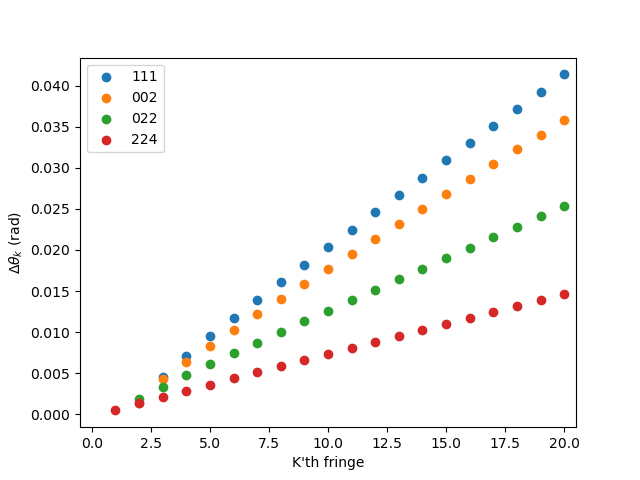

In [82]:
fig, ax = plt.subplots()

ax.scatter(k, dt_111, label = "111")
ax.scatter(k, dt_200, label = "002")
ax.scatter(k, dt_220, label = "022")
ax.scatter(k, dt_224, label = "224")

ax.set_ylabel(r"$\Delta \theta_k$ (rad)")
ax.set_xlabel("K'th fringe")
ax.set_xlim(-0.5, 20.5)

ax.legend()

# Conclusion
The $1/|g|$ dependence on fringe spacing plays stronger than the effect of the increasing extinction distance with higher g. We see that for closer reflections, the absolute distance between fringes is larger (so you will see fewer fringes for the same convergence angle). To see more fringes in the same sized disk, it is advantageous to take a higher order reflection.